In [1]:
%pip install numpy matplotlib scapy[basic] tqdm

  Using cached https://files.pythonhosted.org/packages/62/20/4d43e141b5bc426ba38274933ef8e76e85c7adea2c321ecf9ebf7421cedf/numpy-1.18.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/07/4b361d6d0f4e08942575f83a11d33f36897e1aae4279046606dd1808778a/matplotlib-3.1.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cd/80/5bb262050dd2f30f8819626b7c92339708fe2ed7bd5554c8193b4487b367/tqdm-4.42.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached ht

In [1]:
import random
import numpy as np
from tqdm import tqdm
from scapy.all import PcapReader
from scapy.layers.dot11 import Dot11ProbeReq


def accumulate(file, *accumulators):
    with PcapReader(file) as reader, tqdm(unit='packets', desc=file) as pbar:
        for packet in reader:
            for accumulator in accumulators:
                accumulator(packet)
            pbar.update()
        return accumulators


class TimeSeriesAccumulator(list):
    TYPE = ('timestamp', np.float), ('mac', np.bytes_, 6)
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq):
            timestamp = packet.time
            mac = bytes.fromhex(packet.addr2.replace(':', ''))
            self.append((timestamp, mac))
            
    def as_numpy_array(self):
        return np.array(self, dtype=np.dtype([*self.TYPE]))


class RandomProbeSampler(list):
    PROBABILITY = 0.001
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq) and random.random() <= self.PROBABILITY:
            self.append(packet)

In [2]:
from captures import commutes

commute_time_series = dict()  # commute -> feature matrix
commute_samples = dict()  # commute -> list of probe request samples

for commute in commutes:
    features, samples = accumulate(commute.filename, TimeSeriesAccumulator(), RandomProbeSampler())
    commute_time_series[commute] = features.as_numpy_array()
    commute_samples[commute] = samples

capture-0-a4.pcap: 57279packets [01:02, 915.18packets/s] 
capture-1-a4.pcap: 67268packets [01:15, 886.63packets/s] 
capture-2-a4.pcap: 59223packets [01:05, 902.27packets/s] 
capture-5-a4.pcap: 67624packets [01:09, 974.52packets/s] 
capture-6-a4.pcap: 100160packets [01:34, 1063.79packets/s]
capture-7-a4.pcap: 82099packets [01:27, 936.63packets/s] 


In [6]:
import math


def duration(timestamps):
    return np.amax(timestamps) - np.amin(timestamps)


def frequency_count(timestamps, time_interval):
    number_of_intervals = math.ceil(duration(timestamps) / time_interval)
    counts = np.zeros(number_of_intervals)
    rel_timestamps = timestamps - np.amin(timestamps)
    for timestamp in rel_timestamps:
        counts[math.floor(timestamp / time_interval)] += 1
    return counts


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt


def plot_line_chart(data, x_label=None, y_label=None):
    plt.figure(figsize=(18, 6))
    legends = []
    for xs, ys, legend in data:
        plt.plot(xs, ys)
        legends.append(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(legends)

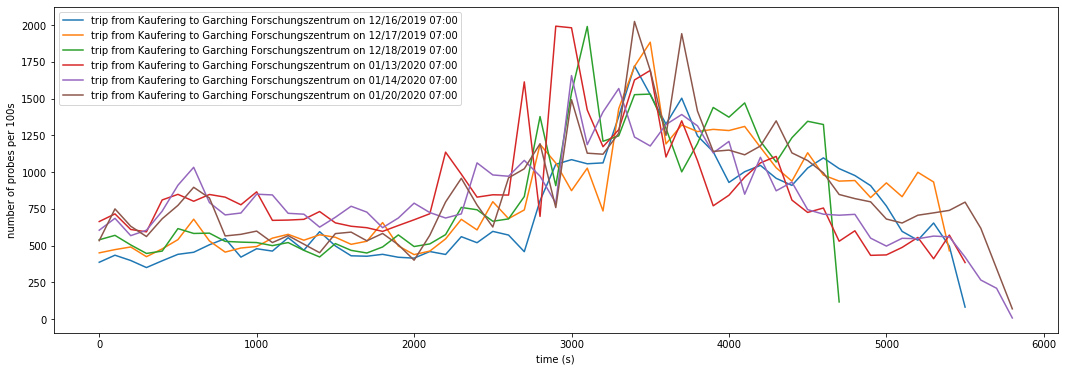

In [10]:
TIME_INTERVAL = 100

plots = []

for commute in commutes:
    legend = '{} on {:%m/%d/%Y %H:%M}'.format(commute.description, commute.start_date)
    timestamps = commute_time_series[commute][:]['timestamp']
    ys = frequency_count(timestamps, TIME_INTERVAL)
    xs = np.arange(0, len(ys) * TIME_INTERVAL, TIME_INTERVAL)
    plots.append((xs, ys, legend))

plot_line_chart(plots, x_label='time (s)', y_label='number of probes per {}s'.format(TIME_INTERVAL))

In [9]:
commute_samples[commutes[0]][0].show()


###[ RadioTap dummy ]### 
  version   = 0
  pad       = 0
  len       = 18
  present   = Flags+Rate+Channel+dBm_AntSignal+Antenna+RXFlags
  Flags     = 
  Rate      = 2
  ChannelFrequency= 2462
  ChannelFlags= CCK+2GHz
  dBm_AntSignal= -22dBm
  Antenna   = 1
  RXFlags   = 
  notdecoded= ''
###[ 802.11 ]### 
     subtype   = 4
     type      = Management
     proto     = 0
     FCfield   = 
     ID        = 0
     addr1     = ff:ff:ff:ff:ff:ff
     addr2     = b8:27:eb:31:a7:83
     addr3     = ff:ff:ff:ff:ff:ff
     SC        = 1584
###[ 802.11 Probe Request ]### 
###[ 802.11 Information Element ]### 
           ID        = SSID
           len       = 0
           info      = ''
###[ 802.11 Rates ]### 
           ID        = 1
           len       = 4
           rates     = [0x2, 0x4, 0xb, 0x16]
###[ 802.11 Information Element ]### 
           ID        = ESRates
           len       = 8
           info      = '\x0c\x12\x18$0H`l'
###[ 802.11 Information Element ]### 
           ID     

In [ ]:
# test

commutes[0]['samples'][0].show()